<a href="https://colab.research.google.com/github/mangohehe/DeepGate2/blob/data-learning/notebooks/open_eda_tooling_treats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎁 Open EDA Tooling Treats

```
Copyright 2021 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Context: https://twitter.com/proppy/status/1466020384063430657

## 🍬 Treat #1: EDA Conda Packages & Notebooks

The [conda-eda](https://github.com/hdl/conda-eda) project maintains a collection of conda packages recipes. Those package can be used to easily bootstrap EDA environments in Jupyter and Colab notebooks.

This notebook shows how to lint Verilog cells and plot the simulated waveforms for a simple 4-bits counter design.

### Install packages

Install packages from the `LiteX-Hub` [channel](https://anaconda.org/LiteX-Hub/repo); also install older packages from the `SymbiFlow` channel, to get better compat with colab: see [conda-eda#146](https://github.com/hdl/conda-eda/issues/146).

In [1]:
!curl -O https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py37_4.10.3-Linux-x86_64.sh -b -f -p miniconda-eda/
!miniconda-eda/bin/conda install --yes -c LiteX-Hub iverilog
!miniconda-eda/bin/conda install --yes -c SymbiFlow verible

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.9M  100 84.9M    0     0  40.3M      0  0:00:02  0:00:02 --:--:-- 40.3M
PREFIX=/content/miniconda-eda
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /content/miniconda-eda

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37h06a4308_0
    - cffi==1.14.6=py37h400218f_0
    - chardet==4.0.0=py37h06a4308_1003
    - conda-package-handling==1.7.3=py37h27cfd23_1
    - conda==4.10.3=py37h06a4308_0
    - cryptography==3.4.7=py37hd23ed53_0
    - idna==2.10=pyhd3eb1b0_0
    - ld_impl_linux-64==2.35.1=h7274673_9
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.3.0=h5101ec6_17
    - libgomp==9.3.0=h5101ec6_17
    - libstdcxx-ng==9.3.0=hd4c

### Lint and simulate Verilog cells

Use the `%%bash` magic to lint the content of the cell with [Verible](https://github.com/chipsalliance/verible) and simulate the test bench using [Icarus Verilog](http://iverilog.icarus.com/).


In [2]:
%%bash -c 'source miniconda-eda/bin/activate; cat > counter.v; verible-verilog-lint counter.v && iverilog counter.v && vvp a.out'

module counter(input clk, input rst, output reg[3:0] out);
  always @ (posedge clk) begin
    if (rst)
      out <= 0;
    else
      out <= out + 1;
  end
endmodule

module counter_tb;
  reg clk;
  reg rst;

  wire [3:0] out;

  counter c1(.clk(clk), .rst(rst), .out(out));

  always #1 clk = !clk;

  initial begin
    $dumpfile("test.vcd");
    $dumpvars(0,counter_tb);
    clk <= 0;
    rst <= 1;
    #1  rst <= 0;
    #11 rst <= 1;
    #1  rst <= 0;
    #51 $finish;
  end
endmodule

VCD info: dumpfile test.vcd opened for output.
counter.v:29: $finish called at 64 (1s)


### Plot VCD waveforms

Use [vcdvcd](https://pypi.org/project/vcdvcd/) VCD parser to plot the simulated waveform using regular matplotlib functions.

In [3]:
!python -m pip install vcdvcd

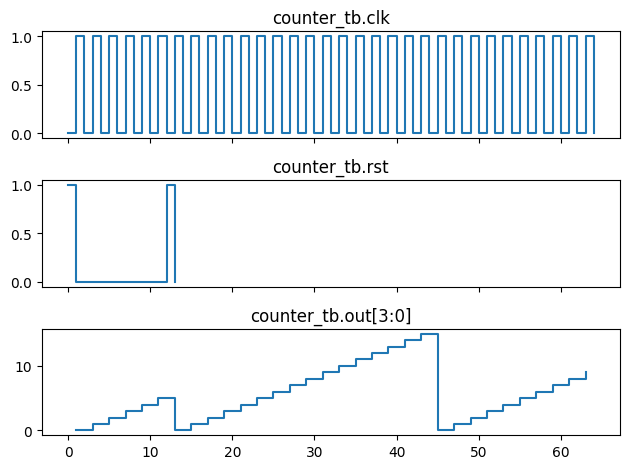

In [4]:
from vcdvcd import VCDVCD

vcd = VCDVCD('test.vcd')
import matplotlib.pyplot as plt
signals = ['counter_tb.clk', 'counter_tb.rst', 'counter_tb.out[3:0]']
f, plots = plt.subplots(len(signals), 1, sharex=True)
for s, plt in zip(signals, plots):
  x, y = zip(*vcd[s].tv)
  y = [int(n, 2) if n != 'x' else None for n in y]
  plt.step(x, y, label=s, where = 'post')
  plt.set_title(s)
f.tight_layout()
f.show()

## 🍡 Treat #2: Yosys synthesis and circuit drawing

[Yosys](https://yosyshq.net/yosys/) is a versatile tool to synthesize HDL designs to netlist and map them to the underlying technology target.

This notebook shows how to synthesize a simple 1-bit adder Verilog design to different levels of technology abstraction (standard logic gates, CMOS, LUTs, discrete ICs) and draw the underlying circuit diagrams.

### Install packages

Install packages from the `LiteX-Hub` and `SymbiFlow` channel.

In [5]:
!curl -O https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py37_4.10.3-Linux-x86_64.sh -b -f -p miniconda-synth/
!miniconda-synth/bin/conda install --yes -c LiteX-Hub yosys
!miniconda-synth/bin/conda install --yes -c SymbiFlow verible

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.9M  100 84.9M    0     0  40.7M      0  0:00:02  0:00:02 --:--:-- 40.7M
PREFIX=/content/miniconda-synth
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /content/miniconda-synth

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37h06a4308_0
    - cffi==1.14.6=py37h400218f_0
    - chardet==4.0.0=py37h06a4308_1003
    - conda-package-handling==1.7.3=py37h27cfd23_1
    - conda==4.10.3=py37h06a4308_0
    - cryptography==3.4.7=py37hd23ed53_0
    - idna==2.10=pyhd3eb1b0_0
    - ld_impl_linux-64==2.35.1=h7274673_9
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.3.0=h5101ec6_17
    - libgomp==9.3.0=h5101ec6_17
    - libstdcxx-ng==9.3.0=

### Lint Verilog

Use the `%%bash` magic to the `adder` Verilog module with [Verible](https://github.com/chipsalliance/verible).

In [6]:
%%bash -c 'source miniconda-synth/bin/activate; cat > adder.v; verible-verilog-lint adder.v'

module adder(
  input wire a,
  input wire b,
  output wire [1:0] out
);
  assign out = a + b;
endmodule

### Synth design

Synthesize design netlist: map to a single `add` cell.

In [7]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv adder.v
hierarchy -top adder

proc; opt

opt_clean
show -format dot -prefix synth_design
stat


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: adder.v
Parsing SystemVerilog input from `adder.v' to AST representation.
Storing AST representation for module `$abstract\adder'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\adder'.
Generating RTLIL representation for module `\adder'.

3.1. Analyzing design hierarchy..
Top module:  \adder

3.2. Analyzing design hierarchy..
Top module:  \adder
Removing unused module `$abstract\adder'.
Removed 1 unused modules.

yosys> 
yosys> 
4. Executing PROC pass (convert processes to netlists).

4.1. Executing PROC_CLEAN pass (remove empty switches from decision trees).
Cleaned up 0 empty switches.

4.2. Executing PROC_RMDEAD pass (remove dead branches from decision trees).
Removed a total of 0 dead cases.

4.3. Executing PROC_PRUNE pass (remove redundant assignments in processes).
Removed 0 redundant assignme

In [11]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 813.9 kB/s eta 0:00:00


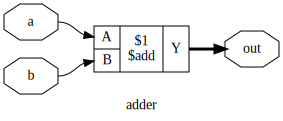

In [12]:
import graphviz
graphviz.Source.from_file('synth_design.dot')

### Synth gates

Synthesize gate netlist: map to built-in `XOR` and `AND` logic gates.

In [9]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv adder.v
hierarchy -top adder

proc; opt
techmap; opt

opt_clean
show -format dot -prefix synth_gate
stat


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: adder.v
Parsing SystemVerilog input from `adder.v' to AST representation.
Storing AST representation for module `$abstract\adder'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\adder'.
Generating RTLIL representation for module `\adder'.

3.1. Analyzing design hierarchy..
Top module:  \adder

3.2. Analyzing design hierarchy..
Top module:  \adder
Removing unused module `$abstract\adder'.
Removed 1 unused modules.

yosys> 
yosys> 
4. Executing PROC pass (convert processes to netlists).

4.1. Executing PROC_CLEAN pass (remove empty switches from decision trees).
Cleaned up 0 empty switches.

4.2. Executing PROC_RMDEAD pass (remove dead branches from decision trees).
Removed a total of 0 dead cases.

4.3. Executing PROC_PRUNE pass (remove redundant assignments in processes).
Removed 0 redundant assignme

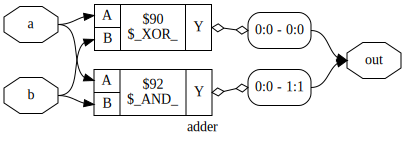

In [13]:
import graphviz
graphviz.Source.from_file('synth_gate.dot')

### Synth FPGA

Synthesize FPGA netlist: map to `IC40` `LUT` gates using a builtin synthesis script.

In [14]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv adder.v
hierarchy -top adder

synth_ice40

opt_clean
show -format dot -prefix synth_ice40


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: adder.v
Parsing SystemVerilog input from `adder.v' to AST representation.
Storing AST representation for module `$abstract\adder'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\adder'.
Generating RTLIL representation for module `\adder'.

3.1. Analyzing design hierarchy..
Top module:  \adder

3.2. Analyzing design hierarchy..
Top module:  \adder
Removing unused module `$abstract\adder'.
Removed 1 unused modules.

yosys> 
yosys> 
4. Executing SYNTH_ICE40 pass.

4.1. Executing Verilog-2005 frontend: /content/miniconda-synth/bin/../share/yosys/ice40/cells_sim.v
Parsing Verilog input from `/content/miniconda-synth/bin/../share/yosys/ice40/cells_sim.v' to AST representation.
Generating RTLIL representation for module `\SB_IO'.
Generating RTLIL representation for module `\SB_GB_IO'.
Generating RTLIL repre

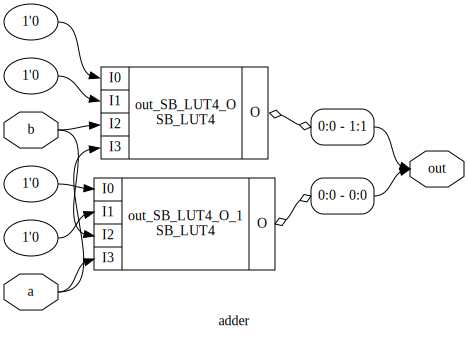

In [15]:
import graphviz
graphviz.Source.from_file('synth_ice40.dot')

### Synth CMOS

Synthesize CMOS netlist: map to `NOR` and `NOT` gates using CMOS technology mapping from `yosys examples.

In [16]:
!curl --silent -L https://github.com/YosysHQ/yosys/archive/refs/tags/yosys-0.11.tar.gz | tar xvzf - yosys-yosys-0.11/examples/cmos --strip-components=2

yosys-yosys-0.11/examples/cmos/
yosys-yosys-0.11/examples/cmos/.gitignore
yosys-yosys-0.11/examples/cmos/README
yosys-yosys-0.11/examples/cmos/cmos_cells.lib
yosys-yosys-0.11/examples/cmos/cmos_cells.sp
yosys-yosys-0.11/examples/cmos/cmos_cells.v
yosys-yosys-0.11/examples/cmos/cmos_cells_digital.sp
yosys-yosys-0.11/examples/cmos/counter.v
yosys-yosys-0.11/examples/cmos/counter.ys
yosys-yosys-0.11/examples/cmos/counter_digital.ys
yosys-yosys-0.11/examples/cmos/counter_tb.gtkw
yosys-yosys-0.11/examples/cmos/counter_tb.v
yosys-yosys-0.11/examples/cmos/testbench.sh
yosys-yosys-0.11/examples/cmos/testbench.sp
yosys-yosys-0.11/examples/cmos/testbench_digital.sh
yosys-yosys-0.11/examples/cmos/testbench_digital.sp


In [17]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv adder.v
hierarchy -top adder

read -sv -lib cmos/cmos_cells.v
synth
dfflibmap -liberty cmos/cmos_cells.lib
abc -liberty cmos/cmos_cells.lib

opt_clean
show -format dot -prefix synth_cmos
stat -liberty cmos/cmos_cells.lib


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: adder.v
Parsing SystemVerilog input from `adder.v' to AST representation.
Storing AST representation for module `$abstract\adder'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\adder'.
Generating RTLIL representation for module `\adder'.

3.1. Analyzing design hierarchy..
Top module:  \adder

3.2. Analyzing design hierarchy..
Top module:  \adder
Removing unused module `$abstract\adder'.
Removed 1 unused modules.

yosys> 
yosys> 
4. Executing Verilog-2005 frontend: cmos/cmos_cells.v
Parsing SystemVerilog input from `cmos/cmos_cells.v' to AST representation.
Storing AST representation for module `$abstract\BUF'.
Storing AST representation for module `$abstract\NOT'.
Storing AST representation for module `$abstract\NAND'.
Storing AST representation for module `$abstract\NOR'.
Storing AST representation

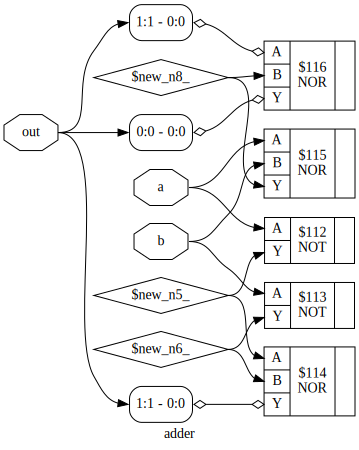

In [18]:
import graphviz
graphviz.Source.from_file('synth_cmos.dot')

### Synth 74xx

Synthesize 74xx netlist: map to `74AC08` a nd `74AC86` discrete gate ICs using community provided technology mapping.

In [19]:
!git clone https://github.com/Ravenslofty/74xx-liberty

Cloning into '74xx-liberty'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 238 (delta 59), reused 58 (delta 58), pack-reused 170
Receiving objects: 100% (238/238), 112.96 KiB | 4.03 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [20]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv adder.v
hierarchy -top adder

read -sv -lib 74xx-liberty/74_models.v
synth
abc -liberty 74xx-liberty/74ac.lib
dfflibmap -liberty 74xx-liberty/74ac.lib

opt_clean
show -format dot -prefix synth_74
stat -liberty 74xx-liberty/74ac.lib


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: adder.v
Parsing SystemVerilog input from `adder.v' to AST representation.
Storing AST representation for module `$abstract\adder'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\adder'.
Generating RTLIL representation for module `\adder'.

3.1. Analyzing design hierarchy..
Top module:  \adder

3.2. Analyzing design hierarchy..
Top module:  \adder
Removing unused module `$abstract\adder'.
Removed 1 unused modules.

yosys> 
yosys> 
4. Executing Verilog-2005 frontend: 74xx-liberty/74_models.v
Parsing SystemVerilog input from `74xx-liberty/74_models.v' to AST representation.
Storing AST representation for module `$abstract\74HC85_1x1CMP4'.
Storing AST representation for module `$abstract\74AC283_1x1ADD4'.
Storing AST representation for module `$abstract\74AC377_8x1DFFE'.
Storing AST representation for mo

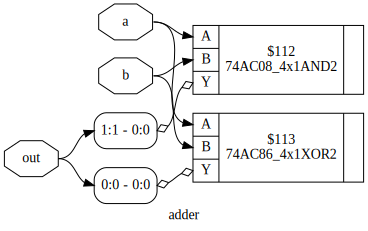

In [21]:
import graphviz
graphviz.Source.from_file('synth_74.dot')

## 🍫Treat #3 nextpnr and SVG floor map

[nextpnr](https://github.com/YosysHQ/nextpnr) is a vendor neutral place and route tool that support multiple FPGA architectures.

It takes [Yosys](https://yosyshq.net/yosys/) synthesis `JSON` output and attemps to place and wire the resulting cells on the target FPGA functional blocks.

This notebook shows the floor map of an `ICE40UP5K` with a simple 8-bit adder that occupies 19 LUTs, and a [Quadratic Polynomial  function from Project F](https://projectf.io/posts/multiplication-fpga-dsps/#quartic-polynomial) that occupies 86% of the available LUTs.

### Install packages

Install packages from the `LiteX-Hub` and `SymbiFlow` channel.

In [22]:
!curl -O https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py37_4.10.3-Linux-x86_64.sh -b -f -p miniconda-pnr/
!miniconda-pnr/bin/conda install -y -c LiteX-Hub yosys nextpnr-ice40
!miniconda-pnr/bin/conda install --yes -c SymbiFlow verible

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.9M  100 84.9M    0     0  30.1M      0  0:00:02  0:00:02 --:--:-- 30.1M
PREFIX=/content/miniconda-pnr
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /content/miniconda-pnr

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37h06a4308_0
    - cffi==1.14.6=py37h400218f_0
    - chardet==4.0.0=py37h06a4308_1003
    - conda-package-handling==1.7.3=py37h27cfd23_1
    - conda==4.10.3=py37h06a4308_0
    - cryptography==3.4.7=py37hd23ed53_0
    - idna==2.10=pyhd3eb1b0_0
    - ld_impl_linux-64==2.35.1=h7274673_9
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.3.0=h5101ec6_17
    - libgomp==9.3.0=h5101ec6_17
    - libstdcxx-ng==9.3.0=hd4c

### Place and Route 8-bit adder

In [23]:
%%bash -c 'source miniconda-pnr/bin/activate; cat > adder8.v; verible-verilog-lint adder8.v'

module adder8(
  input wire [7:0] a,
  input wire [7:0] b,
  output wire [7:0] out
);
  assign out = a + b;
endmodule

In [24]:
!miniconda-pnr/bin/yosys -p 'synth_ice40 -top adder8 -json adder8.json' adder8.v
!miniconda-pnr/bin/nextpnr-ice40 --up5k --json adder8.json --asc adder8.asc --placed-svg adder8_placed.svg


 /----------------------------------------------------------------------------\
 |                                                                            |
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |                                                                            |
 |  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |
 |                                                                            |
 |  Permission to use, copy, modify, and/or distribute this software for any  |
 |  purpose with or without fee is hereby granted, provided that the above    |
 |  copyright notice and this permission notice appear in all copies.         |
 |                                                                            |
 |  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |
 |  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |
 |  MERCHANTABILITY AND FITNESS. IN NO 

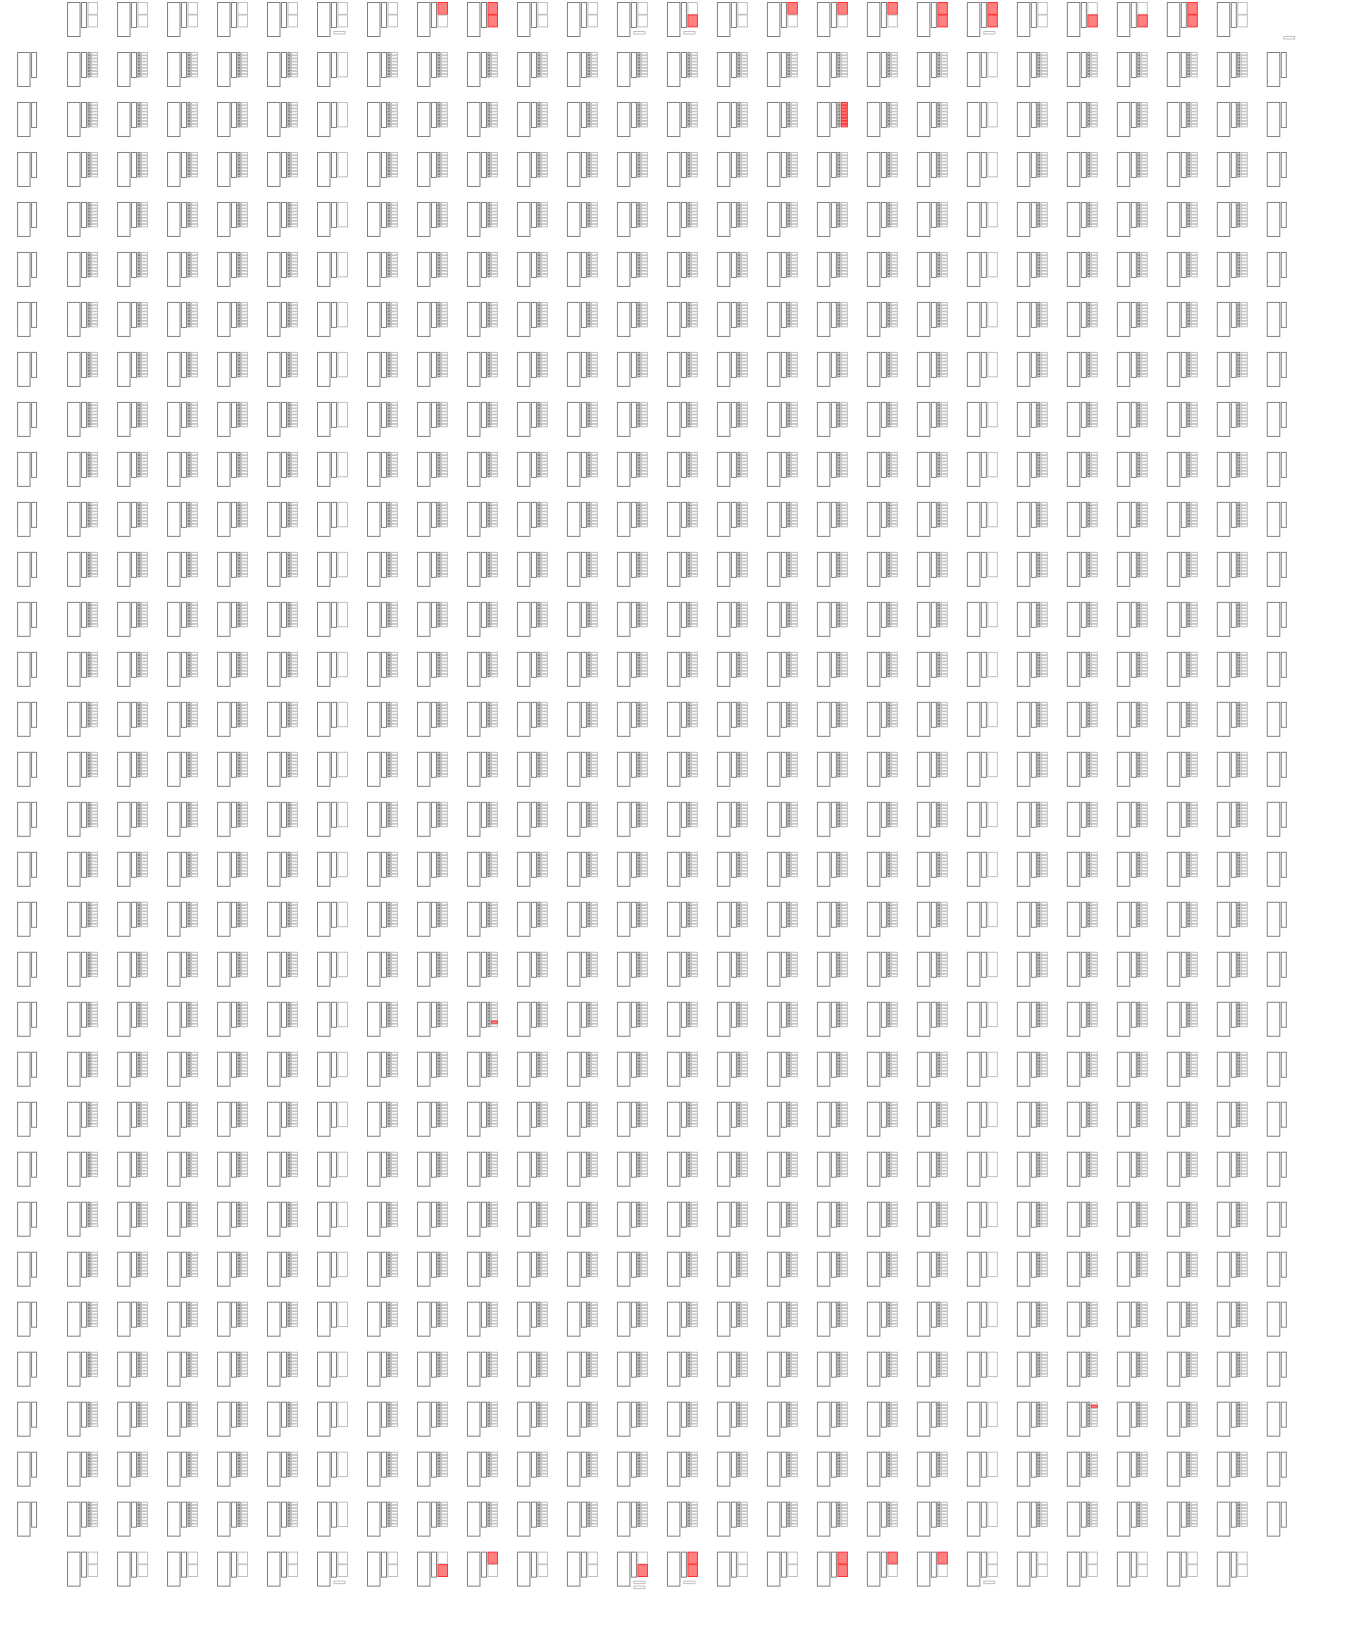

In [25]:
from IPython.display import SVG
SVG(filename='adder8_placed.svg')

### Place and Route 18-bit polynomial function

In [26]:
!git clone https://github.com/projf/projf-explore.git
# make it bigger!
!sed -i -e s/CORDW=8/CORDW=18/ projf-explore/maths/demo/func_polynomial.sv

Cloning into 'projf-explore'...
remote: Enumerating objects: 6664, done.
remote: Counting objects: 100% (1159/1159), done.
remote: Compressing objects: 100% (502/502), done.
remote: Total 6664 (delta 746), reused 931 (delta 614), pack-reused 5505
Receiving objects: 100% (6664/6664), 3.13 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (4550/4550), done.


In [27]:
!miniconda-pnr/bin/yosys -p 'synth_ice40 -top func_polynomial -json func_polynomial.json' projf-explore/maths/demo/func_polynomial.sv
!miniconda-pnr/bin/nextpnr-ice40 --up5k --json func_polynomial.json --asc func_polynomial.asc --placed-svg func_polynomial_placed.svg


 /----------------------------------------------------------------------------\
 |                                                                            |
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |                                                                            |
 |  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |
 |                                                                            |
 |  Permission to use, copy, modify, and/or distribute this software for any  |
 |  purpose with or without fee is hereby granted, provided that the above    |
 |  copyright notice and this permission notice appear in all copies.         |
 |                                                                            |
 |  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |
 |  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |
 |  MERCHANTABILITY AND FITNESS. IN NO 

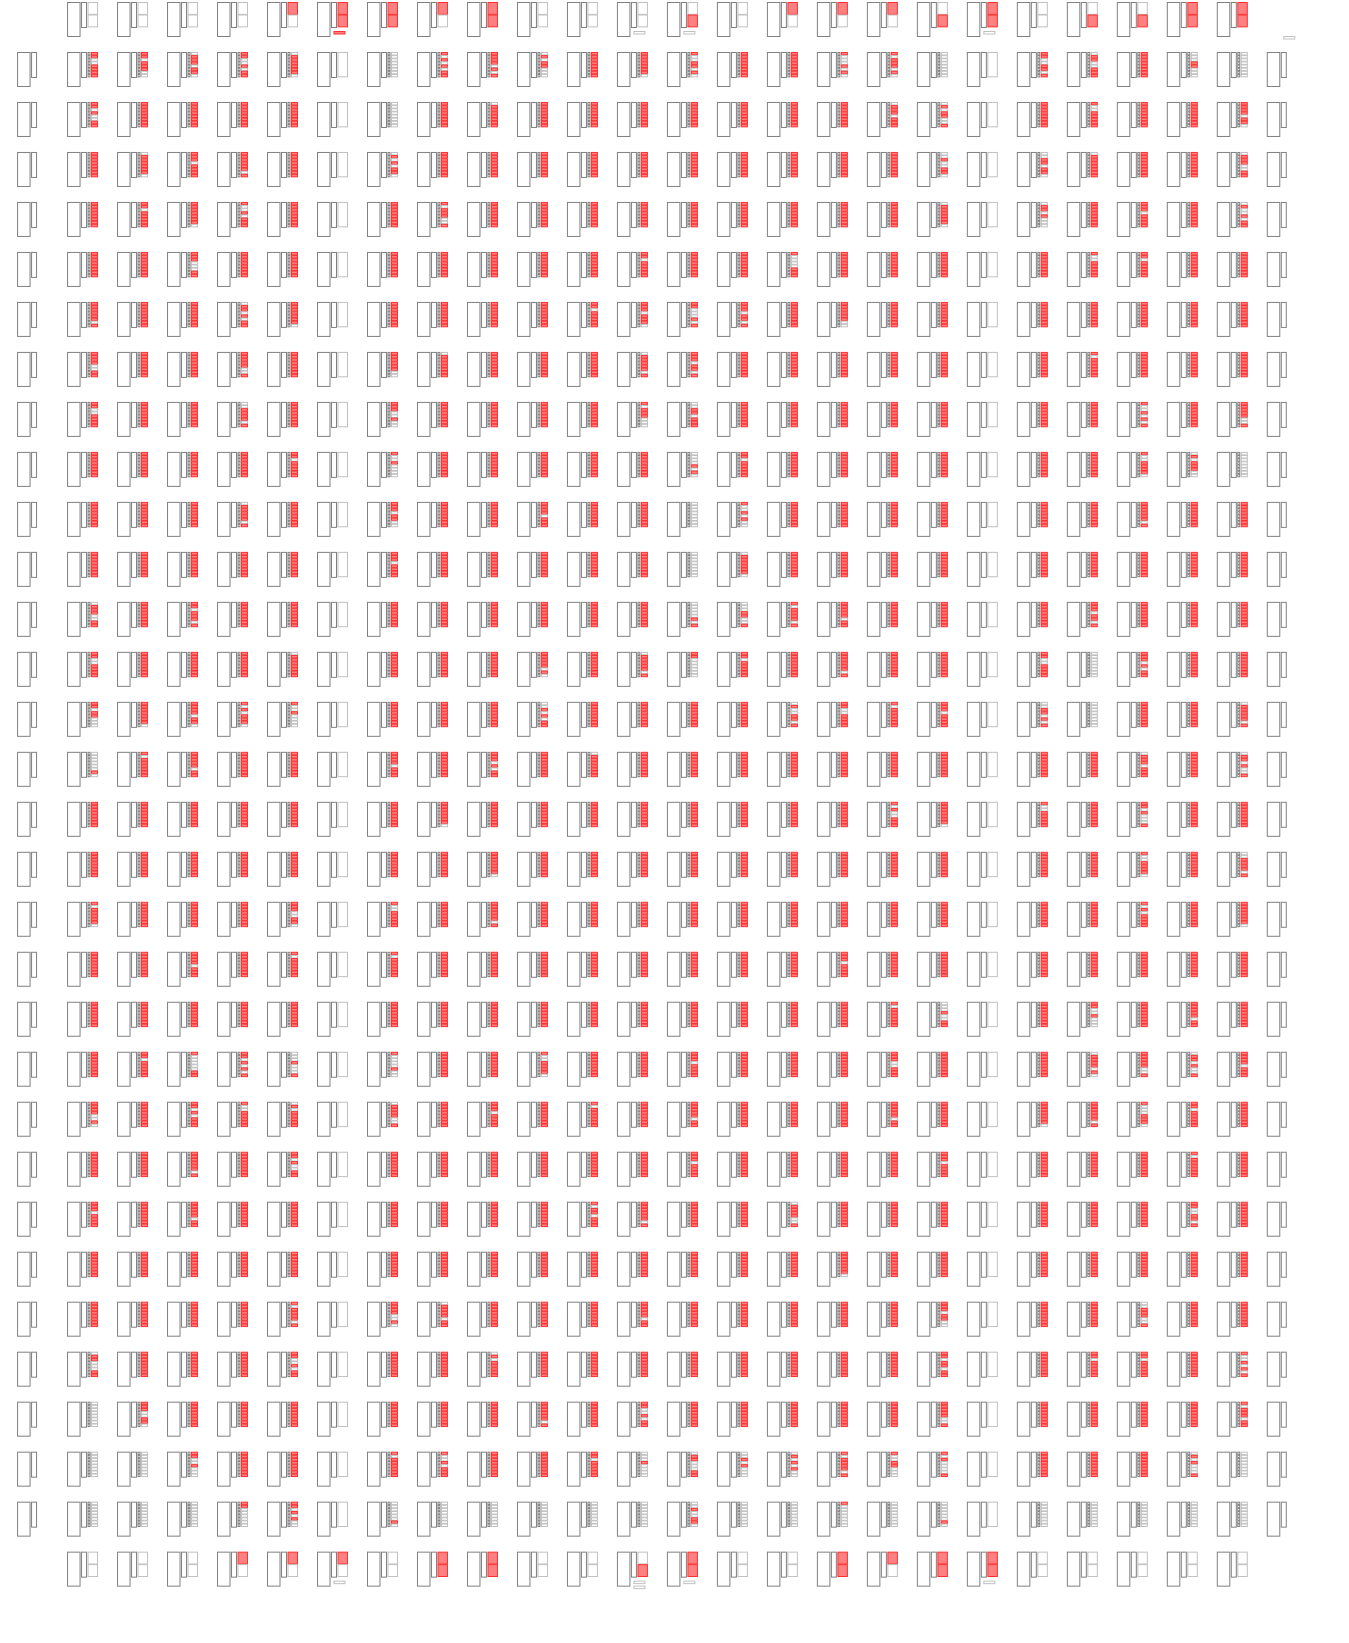

In [28]:
from IPython.display import SVG
SVG(filename='func_polynomial_placed.svg')

## 🧇 Treat #4 OpenROAD

[OpenROAD](https://github.com/The-OpenROAD-Project/OpenROAD) is an unified application that implement a full ASIC RTL-to-GDS Flow.

It can takes [Yosys](https://yosyshq.net/yosys/) synthesis output and attemps to place and wire the resulting cells for a given ASIC process node technology and perform various validation, optimization and reporting tasks.

This notebook shows the incremental floor plans for a simple 8-bit adder, by running the placement and routing steps of the OpenROAD app for the `Nangate_45` technology mapping.

### Install packages

Unpack the OpenROAD tooling layer from the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane) container image distribution (to workaround [colabtools#299](https://github.com/googlecolab/colabtools/issues/299#issuecomment-615308778)) and install synthesis tool from conda.


In [29]:
!apt-get update && apt-get install -y libtcl8.5 tcl-tclreadline jq
!mkdir openlane
!TOKEN=$(curl --silent 'https://auth.docker.io/token?service=registry.docker.io&scope=repository:efabless/openlane:pull' | jq -r '.token') && \
 LAYER=sha256:799e6b187a38d4861827b5adeb1df9eee1f8807e6aab32eff95ffa0234eb3b6f && \
 curl -L --header "Authorization: Bearer $TOKEN" "https://registry-1.docker.io/v2/efabless/openlane/blobs/$LAYER" | tar xvzf - -C openlane
!curl -O https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py37_4.10.3-Linux-x86_64.sh -b -f -p miniconda-openroad/
!miniconda-openroad/bin/conda install -y -c LiteX-Hub yosys
!miniconda-openroad/bin/conda install --yes -c SymbiFlow verible
!git clone https://github.com/The-OpenROAD-Project/OpenROAD
!cp -r OpenROAD/test/Nangate45 .

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 9s (26.2 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libtcl8.5
E: Couldn't find any package by glob 'libtcl8.5'
E: Couldn't find any package by regex 'libtcl8.5'
/bin/bash: line 1: jq: command not found
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 

### Synth design

Synthesize the 8-bit adder design with Yosys using the `Nangate_45` technology mapping.

In [30]:
%%bash -c 'source miniconda-openroad/bin/activate; cat > adder8.v; verible-verilog-lint adder8.v'

module adder8(
  input wire [7:0] a,
  input wire [7:0] b,
  output wire [7:0] out
);
  assign out = a + b;
endmodule

In [31]:
%%script miniconda-openroad/bin/yosys -Q -T

read -sv adder8.v
hierarchy -top adder8

synth
abc -liberty Nangate45/Nangate45_typ.lib
dfflibmap -liberty Nangate45/Nangate45_typ.lib

opt_clean
write_verilog adder8_synth.v
show -format dot -prefix Nangate45
stat -liberty Nangate45/Nangate45_typ.lib


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: adder8.v
Parsing SystemVerilog input from `adder8.v' to AST representation.
Storing AST representation for module `$abstract\adder8'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\adder8'.
Generating RTLIL representation for module `\adder8'.

3.1. Analyzing design hierarchy..
Top module:  \adder8

3.2. Analyzing design hierarchy..
Top module:  \adder8
Removing unused module `$abstract\adder8'.
Removed 1 unused modules.

yosys> 
yosys> 
4. Executing SYNTH pass.

4.1. Executing HIERARCHY pass (managing design hierarchy).

4.1.1. Analyzing design hierarchy..
Top module:  \adder8

4.1.2. Analyzing design hierarchy..
Top module:  \adder8
Removed 0 unused modules.

4.2. Executing PROC pass (convert processes to netlists).

4.2.1. Executing PROC_CLEAN pass (remove empty switches from decision trees).
Clea

### Initialize floor plan

Initialize die and core area, place tap cells and power grid.

In [33]:
%%bash -c 'QT_QPA_PLATFORM=offscreen openlane/build/bin/openroad -exit'
source "Nangate45/Nangate45.vars"
read_lef "Nangate45/Nangate45_tech.lef"
read_lef "Nangate45/Nangate45_stdcell.lef"
read_liberty "Nangate45/Nangate45_typ.lib"

read_verilog "adder8_synth.v"
link_design "adder8"

initialize_floorplan -site "FreePDK45_38x28_10R_NP_162NW_34O" \
                     -die_area {0 0 50 50} \
                     -core_area {10 10 40 40}
source "Nangate45/Nangate45.tracks"
remove_buffers
tapcell -distance 120 -tapcell_master "FILLCELL_X1" -endcap_master "FILLCELL_X1"
pdngen -verbose "Nangate45/Nangate45.pdn"

write_db "floor.db"
save_image -resolution 0.1 "floor.png"

bash: line 1: openlane/build/bin/openroad: No such file or directory


CalledProcessError: Command 'b'source "Nangate45/Nangate45.vars"\nread_lef "Nangate45/Nangate45_tech.lef"\nread_lef "Nangate45/Nangate45_stdcell.lef"\nread_liberty "Nangate45/Nangate45_typ.lib"\n\nread_verilog "adder8_synth.v"\nlink_design "adder8"\n\ninitialize_floorplan -site "FreePDK45_38x28_10R_NP_162NW_34O" \\\n                     -die_area {0 0 50 50} \\\n                     -core_area {10 10 40 40}\nsource "Nangate45/Nangate45.tracks"\nremove_buffers\ntapcell -distance 120 -tapcell_master "FILLCELL_X1" -endcap_master "FILLCELL_X1"\npdngen -verbose "Nangate45/Nangate45.pdn"\n\nwrite_db "floor.db"\nsave_image -resolution 0.1 "floor.png"\n'' returned non-zero exit status 127.

In [ ]:
from IPython.display import Image
Image("floor.png")

### Global placement

In [ ]:
%%bash -c 'QT_QPA_PLATFORM=offscreen openlane/build/bin/openroad -exit'
source "Nangate45/Nangate45.vars"
read_lef "Nangate45/Nangate45_tech.lef"
read_lef "Nangate45/Nangate45_stdcell.lef"
read_liberty "Nangate45/Nangate45_typ.lib"
read_db "floor.db"

global_placement -routability_driven -density 0.3  -pad_left 3 -pad_right 3
place_pins -hor_layers "metal3" -ver_layers "metal2"
write_db "placed_global.db"
save_image -resolution 0.1 "placed_global.png"

In [ ]:
from IPython.display import Image
Image("placed_global.png")

### Detailed placement

In [ ]:
%%bash -c 'QT_QPA_PLATFORM=offscreen openlane/build/bin/openroad -exit'
source "Nangate45/Nangate45.vars"
read_lef "Nangate45/Nangate45_tech.lef"
read_lef "Nangate45/Nangate45_stdcell.lef"
read_liberty "Nangate45/Nangate45_typ.lib"
read_db "placed_global.db"

set_placement_padding -global -left 1 -right 1
detailed_placement
filler_placement "FILLCELL"
write_db "placed_detail.db"
save_image -resolution 0.1 "placed_detail.png"

In [ ]:
from IPython.display import Image
Image("placed_detail.png")

### Global routing

Generate guide for detailed routing and congestion data.

In [ ]:
%%bash -c 'QT_QPA_PLATFORM=offscreen openlane/build/bin/openroad -exit'
source "Nangate45/Nangate45.vars"
read_lef "Nangate45/Nangate45_tech.lef"
read_lef "Nangate45/Nangate45_stdcell.lef"
read_liberty "Nangate45/Nangate45_typ.lib"
read_db "placed_detail.db"


set_global_routing_layer_adjustment {metal2-metal10} 0.5
set_routing_layers -signal metal2-metal10
global_route -guide_file "route.guide" -congestion_iterations 100
write_db "routed_global.db"
save_image -resolution 0.1 -display_option {"Heat Maps/Routing Congestion" true} "routed_global.png"

In [ ]:
from IPython.display import Image
Image("routed_global.png")

### Detailed routing

In [ ]:
%%bash -c 'QT_QPA_PLATFORM=offscreen openlane/build/bin/openroad -exit'
source "Nangate45/Nangate45.vars"
read_lef "Nangate45/Nangate45_tech.lef"
read_lef "Nangate45/Nangate45_stdcell.lef"
read_liberty "Nangate45/Nangate45_typ.lib"
read_db "placed_detail.db"

detailed_route -guide "route.guide"
write_db "routed_detail.db"
write_def "routed_detail.def"
save_image -resolution 0.1 "routed_detail.png"

In [ ]:
from IPython.display import Image
Image("routed_detail.png")

---
## 🚧 WIP AREA 🚧
---

Below goes work in progress content for upcoming treats.

### magic stuff

In [ ]:
!apt-get update && apt-get install -y libtcl8.5 tcl-tclreadline jq csh
!mkdir openlane-sky130
!TOKEN=$(curl --silent 'https://auth.docker.io/token?service=registry.docker.io&scope=repository:efabless/openlane:pull' | jq -r '.token') && \
 LAYER=sha256:799e6b187a38d4861827b5adeb1df9eee1f8807e6aab32eff95ffa0234eb3b6f && \
 curl -L --header "Authorization: Bearer $TOKEN" "https://registry-1.docker.io/v2/efabless/openlane/blobs/$LAYER" | tar xvzf - -C openlane-sky130
!curl -O https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py37_4.10.3-Linux-x86_64.sh -b -f -p miniconda-sky130
!miniconda-sky130/bin/conda install -y -c LiteX-Hub yosys
!miniconda-sky130/bin/conda install --yes -c SymbiFlow verible

In [ ]:
!git clone https://github.com/The-OpenROAD-Project/OpenROAD
!cp -r OpenROAD/test/sky130hd .
!cp OpenROAD/test/gcd_sky130hd.v .

In [ ]:
%%bash -c 'QT_QPA_PLATFORM=offscreen openlane-sky130/build/bin/openroad -exit'
source "sky130hd/sky130hd.vars"
read_lef "sky130hd/sky130hd.tlef"
read_lef "sky130hd/sky130hd_std_cell.lef"
read_liberty "sky130hd/sky130hd_tt.lib"
read_liberty "sky130hd/sky130_fd_sc_hd__ff_n40C_1v95.lib"

read_verilog "gcd_sky130hd.v"
link_design "gcd"

initialize_floorplan -site "unithd" \
                     -die_area {0 0 299.96 300.128} \
                     -core_area {9.996 10.08 289.964 290.048}
source "sky130hd/sky130hd.tracks"
remove_buffers
tapcell -distance 14 -tapcell_master "sky130_fd_sc_hd__tapvpwrvgnd_1"
pdngen -verbose "sky130hd/sky130hd.pdn"

global_placement -routability_driven -density 0.3  -pad_left 4 -pad_right 4
place_pins -hor_layers "met3" -ver_layers "met2"

set_placement_padding -global -left 2 -right 2
detailed_placement
filler_placement "sky130_fd_sc_hd__fill_*"

set_global_routing_layer_adjustment {met1-met5} 0.5

set_routing_layers -signal met1-met5
global_route -guide_file "route.guide" -congestion_iterations 100

detailed_route -guide "route.guide"
write_db "gcd_routed_detail.db"
write_def "gcd_routed_detail.def"
save_image -resolution 0.1 "gcd_routed_detail.png"

In [ ]:
%%bash -c 'QT_QPA_PLATFORM=offscreen openlane-sky130/build/bin/openroad -exit'
source "sky130hd/sky130hd.vars"
read_lef "sky130hd/sky130hd.tlef"
read_lef "sky130hd/sky130hd_std_cell.lef"
read_liberty "sky130hd/sky130hd_tt.lib"
read_liberty "sky130hd/sky130_fd_sc_hd__ff_n40C_1v95.lib"

read_db "gcd_routed_detail.db"
save_image -resolution 0.1 "gcd_routed_detail.png"

In [ ]:
!curl --silent http://opencircuitdesign.com/magic/archive/magic-8.3.243.tgz | tar xvzf -
!cd magic-8.3.243 && ./configure && make clean && make && make install

In [ ]:
%%bash -c "/usr/local/bin/magic -dnull -noconsole"
drc off

lef read "sky130hd/sky130hd.tlef"
lef read "sky130hd/sky130hd_std_cell.lef"
def read "gcd_routed_detail.def"

load gcd
select top cell

box 0um 0um 299.96um 300.128um
property FIXED_BBOX [box values]

gds write gcd_sky130.gds

exit 0

In [ ]:
 %%script /usr/local/bin/magic -dnull -noconsole

box 0 0 0 0
drc off
snap int
lef read "sky130hd/sky130hd.tlef"
lef read "sky130hd/sky130hd_std_cell.lef"
gds readonly true
gds rescale false
def read "gcd_routed_detail.def"
load gcd
select top cell
expand
gds write "gcd_tapped.gds"
quit -noprompt

### wasm stuff

In [ ]:
!pip install yowasp-yosys

In [ ]:
%%writefile adder.v

module adder(
  input wire a,
  input wire b,
  output wire [1:0] out
);
  assign out = a + b;
endmodule

In [ ]:
import yowasp_yosys as yosys
import graphviz

script = '; '.join("""
read -sv adder.v
hierarchy -top adder

proc; opt
techmap; opt

opt_clean
show -format dot -prefix adder
stat
""".splitlines())
result = yosys.run_yosys(['-Q', '-T', '-p', f'"{script}"'])
if result == 0:
  graphviz.Source.from_file('synth_adder.dot')
else:
  print('yosys error')

### OpenROAD python stuff

In [ ]:
%%script openlane/build/bin/openroad -python
import openroad
import odb
import os
import json
openroad.openroad_version()
db = odb.dbDatabase.create()
odb.read_lef(db, "Nangate45/Nangate45_tech.lef")
odb.read_lef(db, "Nangate45/Nangate45_stdcell.lef")
odb.read_lef(db, "Nangate45/Nangate45.lef")
odb.read_def(db, "routed_detail.def")
chip = db.getChip()
block = chip.getBlock()
with open('routed_detail.json', 'w') as f:
  json.dump({
      'block': {
        'bbox' : [
          block.getBBox().xMin(),
          block.getBBox().yMin(),
          block.getBBox().xMax(),
          block.getBBox().yMax()
        ],
        'insts' :[{
          'name': inst.getName(),
          'bbox': [
            inst.getBBox().xMin(),
            inst.getBBox().yMin(),
            inst.getBBox().xMax(),
            inst.getBBox().yMax()
          ]
        } for inst in block.getInsts()],
        'nets': [{
            'name': net.getName(),
            'wire': {
              'bbox': [
                net.getWire().getBBox()[1].xMin(),
                net.getWire().getBBox()[1].yMin(),
                net.getWire().getBBox()[1].xMax(),
                net.getWire().getBBox()[1].yMax()
              ]
            }
        } for net in block.getNets() if net.getWire()]
      }
  }, f)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
fig, ax = plt.subplots(dpi=200)
with open('routed_detail.json') as f:
  chip = json.load(f)
  for inst in chip['block']['insts']:
    bbox = inst['bbox']
    filler = 'FILLER' in inst['name']
    ax.add_patch(mpatches.Rectangle(
        bbox[0:2], bbox[2]-bbox[0], bbox[3]-bbox[1],
        color='black' if filler else 'red',
        fill=not filler
        ))
ax.set_aspect('equal')
ax.autoscale_view()
plt.show()